In [2]:

"""
idp_rl Analysis Example
=============================
View the notebook in Google Colab: https://drive.google.com/drive/folders/1WAnTv4SGwEQHHqyMcbrExzUob_mOfTcM?usp=sharing

This notebook gives examples of how the analysis functions in idp_rl can be used.
The example data (example_data1.pickle, example_data2.pickle and example_data3.pickle) were all
data taken from different evaluation episodes of an actual run.

The full API reference for the analysis module can be found at: 
"""
import sys
sys.path.append("..")

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="darkgrid")
from idp_rl import analysis

In [3]:
"""
Loading the data
----------------

We load the data by specifying the filenames of the .pickle files to load. Note that we can
load multiple sets of data. In this example, each data corresponds to a different evaluation episode
taken at different points in the training of an agent. By loading all three datasets we can compare the
performance of the agent across all three episodes.

We can also specify labels for the data (which will appear in the Seaborn plots).
"""
# Specify data files to load
files = [
    'chignolin_4.pickle',
]

# Specify labels for each data set
labels = [
    'chignolin_4',
]

data = analysis.load_data_from_pickle(files, labels)

In [4]:
import rdkit.Chem.AllChem as Chem

mol = data['mol'][0] 
Chem.MMFFSanitizeMolecule(mol)
mmff_props = Chem.MMFFGetMoleculeProperties(mol)

energies = []
for i in range(1000):
    ff = Chem.MMFFGetMoleculeForceField(mol, mmff_props, confId=i)
    energy = ff.CalcEnergy()
    energies.append(energy)

[12:12:54] Molecule does not have explicit Hs. Consider calling AddHs()


In [5]:
sorted_energies = sorted(energies)
indices = np.argsort(energies)

(array([  5.,  10.,  37.,  98., 137., 152., 148., 121.,  92.,  50.]),
 array([249.54612282, 262.63575588, 275.72538893, 288.81502199,
        301.90465504, 314.9942881 , 328.08392116, 341.17355421,
        354.26318727, 367.35282033, 380.44245338]),
 <BarContainer object of 10 artists>)

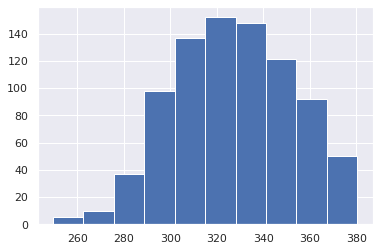

In [6]:
plt.hist(sorted_energies[:-150])

In [7]:
chignolin = Chem.rdmolfiles.MolFromPDBFile("truth/1UAO.pdb", removeHs=False)
Chem.MMFFSanitizeMolecule(chignolin)
mmff_props = Chem.MMFFGetMoleculeProperties(chignolin)

[12:13:03] Molecule does not have explicit Hs. Consider calling AddHs()


In [8]:
true_energies = []

for i in range(18):
    ff = Chem.MMFFGetMoleculeForceField(chignolin, mmff_props, confId=i)
    energy = ff.CalcEnergy()
    true_energies.append(energy)

In [9]:
sorted_true_energies = sorted(true_energies)

(array([1., 1., 1., 1., 4., 1., 3., 3., 1., 2.]),
 array([311.28216195, 316.08875261, 320.89534326, 325.70193392,
        330.50852458, 335.31511523, 340.12170589, 344.92829655,
        349.7348872 , 354.54147786, 359.34806852]),
 <BarContainer object of 10 artists>)

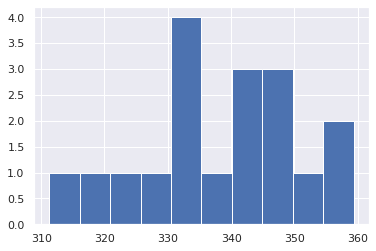

In [10]:
plt.hist(sorted_true_energies)

Text(0.5, 0, '$\\mathcal{E}_{MMFF}$')

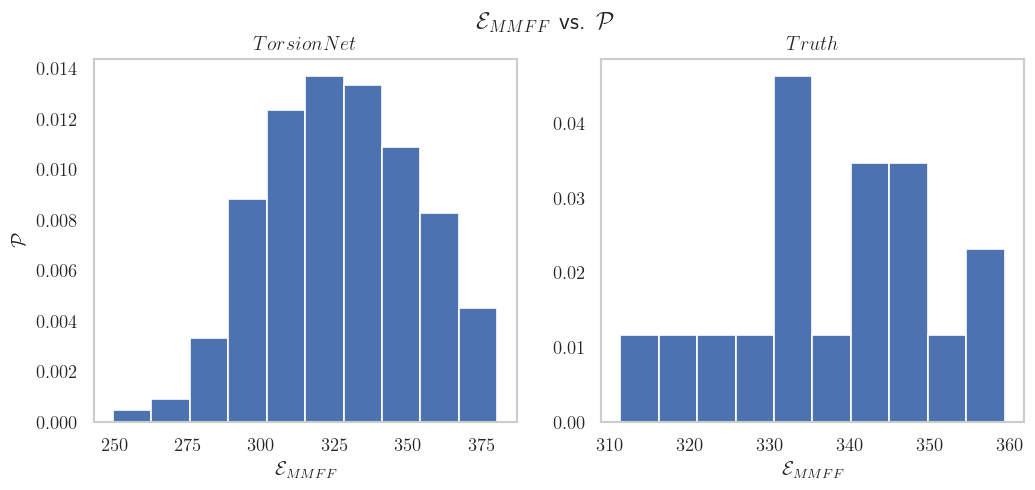

In [11]:
plt.rcParams["axes.grid"] = False
sns.set_style("whitegrid")
plt.rcParams['text.usetex'] = True
plt.rcParams["axes.grid"] = False
blue, = sns.color_palette("muted", 1)

fig, axs = plt.subplots(1, 2, figsize=(10, 4), dpi=120)
axs[0].hist(sorted_energies[:-150], density=True)
axs[1].hist(sorted_true_energies, density=True)

fig.suptitle('$\mathcal{E}_{MMFF}$ vs. $\mathcal{P}$')
axs[0].set_title('$TorsionNet$')
axs[0].set_xlabel('$\mathcal{E}_{MMFF}$')
axs[0].set_ylabel('$\mathcal{P}$')

axs[1].set_title('$Truth$')
axs[1].set_xlabel('$\mathcal{E}_{MMFF}$')
# axs[1].set_ylabel('$\mathcal{P}$')

In [12]:
from rdkit.Chem import TorsionFingerprints
from rdkit.Chem import rdMolTransforms

nonring, _ = TorsionFingerprints.CalculateTorsionLists(mol)
full_dihedrals = []
for tmp_idx in range(18):
    conf_id = int(indices[tmp_idx])
    conf = mol.GetConformer(conf_id)
    
    ff = Chem.MMFFGetMoleculeForceField(mol, mmff_props, confId=conf_id)
    energy = ff.CalcEnergy()
    
    dihedral_angles = []
    for torsion_tup in nonring:
        dihedral_angle = rdMolTransforms.GetDihedralDeg(conf, *torsion_tup[0][0])
        if dihedral_angle < 0:
            dihedral_angle += 360
        dihedral_angles.append(dihedral_angle)
    full_dihedrals.append(dihedral_angles)
full_dihedrals = np.array(full_dihedrals)

In [13]:
nonring, _ = TorsionFingerprints.CalculateTorsionLists(chignolin)
full_true_dihedrals = []
for conf_id in range(chignolin.GetNumConformers()):
    conf = chignolin.GetConformer(conf_id)
    dihedral_angles = []
    for torsion_tup in nonring:
        dihedral_angle = rdMolTransforms.GetDihedralDeg(conf, *torsion_tup[0][0])
        if dihedral_angle < 0:
            dihedral_angle += 360
        dihedral_angles.append(dihedral_angle)
    full_true_dihedrals.append(dihedral_angles)
full_true_dihedrals = np.array(full_true_dihedrals)

Text(0.5, 1.0, '$Truth$')

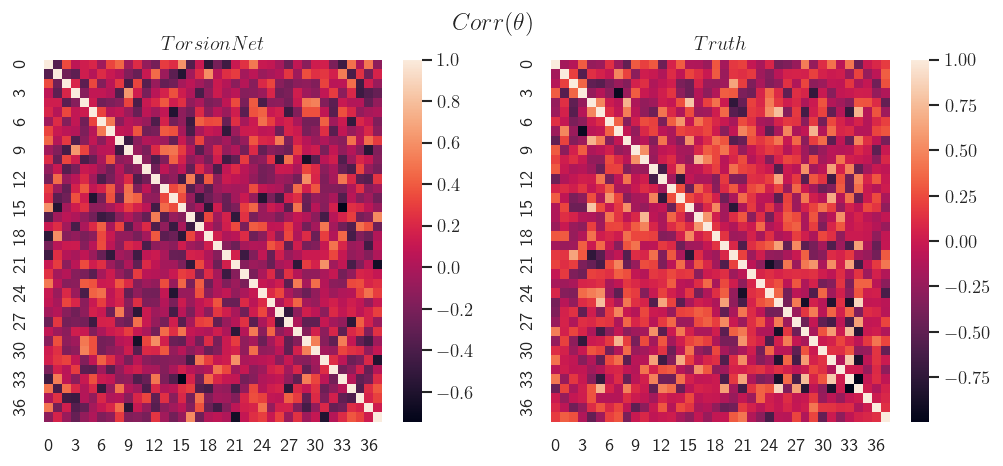

In [14]:
plt.rcParams["axes.grid"] = False
sns.set_style("whitegrid")
plt.rcParams['text.usetex'] = True
plt.rcParams["axes.grid"] = False
blue, = sns.color_palette("muted", 1)

torsion_net_corr = np.corrcoef(full_dihedrals.T)
true_corr = np.corrcoef(full_true_dihedrals.T)

fig, axs = plt.subplots(1, 2, figsize=(10, 4), dpi=120)
sns.heatmap(torsion_net_corr, ax=axs[0])
sns.heatmap(true_corr, ax=axs[1])

fig.suptitle('$Corr(\\theta)$')
axs[0].set_title('$TorsionNet$')
axs[1].set_title('$Truth$')

In [15]:
np.linalg.norm(torsion_net_corr - true_corr)

14.66727633152168

In [16]:
np.linalg.norm((np.random.random(torsion_net_corr.shape) * 2 - 1) - (np.random.random(torsion_net_corr.shape) * 2 - 1))

31.140478938693267

Text(0.5, 1.0, '$Truth$')

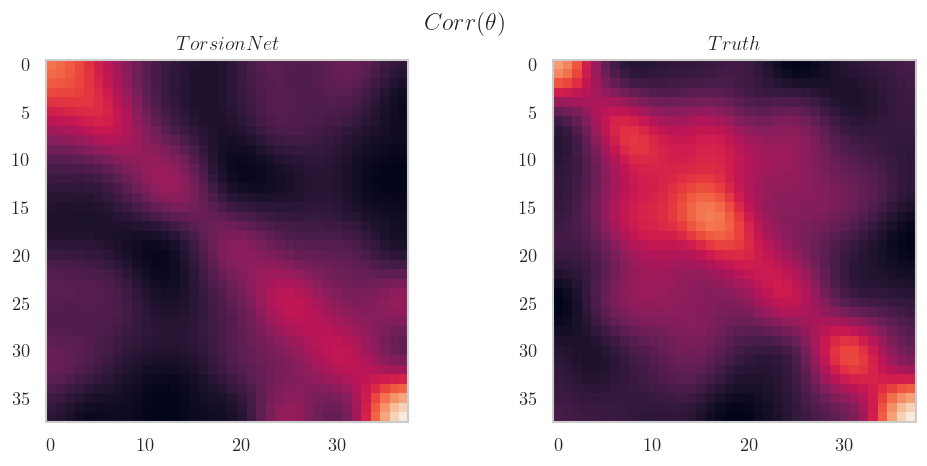

In [17]:
from scipy.ndimage.filters import gaussian_filter

torsion_net_corr_blurred = gaussian_filter(torsion_net_corr, sigma=3)
true_corr_blurred = gaussian_filter(true_corr, sigma=3)

fig, axs = plt.subplots(1, 2, figsize=(10, 4), dpi=120)
axs[0].imshow(torsion_net_corr_blurred)
axs[1].imshow(true_corr_blurred)

fig.suptitle('$Corr(\\theta)$')
axs[0].set_title('$TorsionNet$')
axs[1].set_title('$Truth$')

In [22]:
from rdkit.Chem import TorsionFingerprints
from rdkit.Chem import rdMolTransforms

nonring, _ = TorsionFingerprints.CalculateTorsionLists(mol)
full_dihedrals = []
full_true_dihedrals = []
for tmp_idx in range(18):
    conf_id = int(indices[tmp_idx])
    conf = mol.GetConformer(conf_id)
    true_conf = chignolin.GetConformer(tmp_idx)
    
    dihedral_angles = []
    true_dihedral_angles = []
    for torsion_tup in nonring:
        dihedral_angle = rdMolTransforms.GetDihedralDeg(conf, *torsion_tup[0][0])
        if dihedral_angle < 0:
            dihedral_angle += 360
        dihedral_angles.append(dihedral_angle)

        true_dihedral_angle = rdMolTransforms.GetDihedralDeg(true_conf, *torsion_tup[0][0])
        if true_dihedral_angle < 0:
            true_dihedral_angle += 360
        true_dihedral_angles.append(true_dihedral_angle)
    full_dihedrals.append(dihedral_angles)
    full_true_dihedrals.append(true_dihedral_angles)
full_dihedrals = np.array(full_dihedrals)
full_true_dihedrals = np.array(full_true_dihedrals)

Text(0.5, 1.0, '$Truth$')

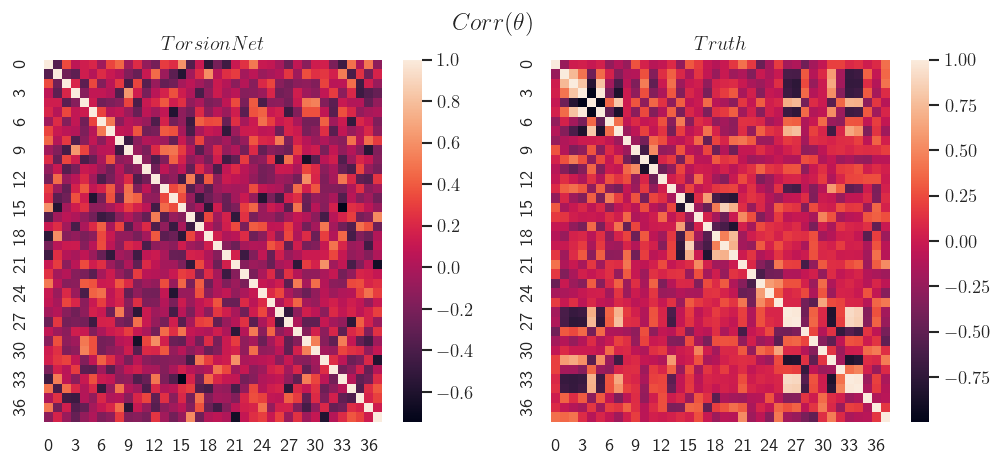

In [25]:
plt.rcParams["axes.grid"] = False
sns.set_style("whitegrid")
plt.rcParams['text.usetex'] = True
plt.rcParams["axes.grid"] = False
blue, = sns.color_palette("muted", 1)

torsion_net_corr = np.corrcoef(full_dihedrals.T)
true_corr = np.corrcoef(full_true_dihedrals.T)

fig, axs = plt.subplots(1, 2, figsize=(10, 4), dpi=120)
sns.heatmap(torsion_net_corr, ax=axs[0])
sns.heatmap(true_corr, ax=axs[1])

fig.suptitle('$Corr(\\theta)$')
axs[0].set_title('$TorsionNet$')
axs[1].set_title('$Truth$')

Text(0.5, 1.0, '$Truth$')

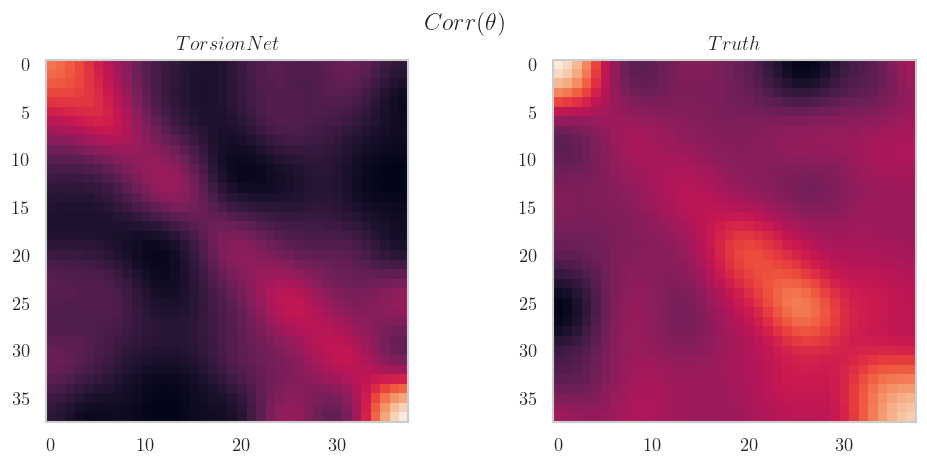

In [27]:
from scipy.ndimage.filters import gaussian_filter

torsion_net_corr_blurred = gaussian_filter(torsion_net_corr, sigma=3)
true_corr_blurred = gaussian_filter(true_corr, sigma=3)

fig, axs = plt.subplots(1, 2, figsize=(10, 4), dpi=120)
axs[0].imshow(torsion_net_corr_blurred)
axs[1].imshow(true_corr_blurred)

fig.suptitle('$Corr(\\theta)$')
axs[0].set_title('$TorsionNet$')
axs[1].set_title('$Truth$')


In [32]:
Chem.EmbedMultipleConfs(mol, numConfs=1, useRandomCoords=True)
Chem.MMFFOptimizeMolecule(mol, confId=0)
# mol.GetNumConformers()

[20:44:10] Molecule does not have explicit Hs. Consider calling AddHs()
[20:44:11] Molecule does not have explicit Hs. Consider calling AddHs()


1

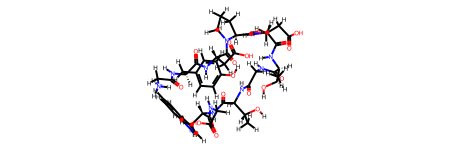

In [29]:
chignolin

In [51]:
stripped_mol = Chem.rdmolops.RemoveHs(mol)
stripped_chignolin = Chem.rdmolops.RemoveHs(chignolin)

stripped_nonring_mol, _ = TorsionFingerprints.CalculateTorsionLists(stripped_mol)
stripped_nonring_chignolin, _ = TorsionFingerprints.CalculateTorsionLists(stripped_chignolin)

In [59]:
sorted_stripped_nonring_mol = sorted([el[0] for el in stripped_nonring_mol])
sorted_stripped_nonring_mol

[[(4, 2, 1, 0)],
 [(5, 4, 2, 3)],
 [(7, 6, 5, 4)],
 [(8, 7, 6, 5), (12, 7, 6, 5)],
 [(14, 5, 4, 2)],
 [(15, 14, 5, 4)],
 [(17, 16, 14, 15)],
 [(19, 18, 17, 22)],
 [(20, 19, 18, 17)],
 [(22, 17, 16, 14)],
 [(23, 22, 17, 16)],
 [(25, 24, 22, 17)],
 [(31, 29, 26, 27)],
 [(32, 31, 29, 30)],
 [(33, 32, 31, 29)],
 [(34, 33, 32, 31)],
 [(35, 34, 33, 32)],
 [(36, 35, 34, 33)],
 [(39, 38, 32, 31)],
 [(41, 40, 38, 39)],
 [(42, 41, 40, 38)],
 [(44, 42, 41, 40)],
 [(46, 45, 41, 40)],
 [(48, 47, 45, 46)],
 [(49, 48, 47, 45)],
 [(51, 49, 48, 47)],
 [(52, 51, 49, 50)],
 [(55, 53, 52, 51)],
 [(56, 52, 51, 49)],
 [(57, 56, 52, 51)],
 [(59, 58, 56, 57)],
 [(61, 60, 59, 70)],
 [(62, 61, 60, 59)],
 [(70, 59, 58, 56)],
 [(71, 70, 59, 60)],
 [(73, 72, 70, 71)],
 [(74, 73, 72, 70)],
 [(75, 74, 73, 72), (76, 74, 73, 72)]]

In [58]:
sorted_stripped_nonring_chignolin = sorted([el[0] for el in stripped_nonring_chignolin])
sorted_stripped_nonring_chignolin

[[(4, 2, 1, 0)],
 [(5, 4, 2, 3)],
 [(6, 5, 4, 2)],
 [(7, 6, 5, 4)],
 [(9, 8, 5, 4)],
 [(10, 9, 8, 5), (11, 9, 8, 5)],
 [(17, 16, 6, 7)],
 [(18, 17, 16, 6)],
 [(19, 18, 17, 16)],
 [(21, 20, 17, 18)],
 [(22, 21, 20, 17)],
 [(30, 24, 18, 17)],
 [(31, 26, 25, 28)],
 [(32, 31, 26, 27)],
 [(34, 33, 32, 31)],
 [(35, 32, 31, 26)],
 [(36, 35, 32, 31)],
 [(37, 36, 35, 32)],
 [(38, 37, 36, 35)],
 [(41, 40, 33, 34)],
 [(43, 42, 41, 40)],
 [(44, 41, 40, 33)],
 [(46, 44, 41, 40)],
 [(48, 47, 42, 43)],
 [(49, 48, 47, 42)],
 [(51, 49, 48, 47)],
 [(52, 51, 49, 50)],
 [(53, 52, 51, 49)],
 [(54, 53, 52, 51)],
 [(57, 55, 52, 51)],
 [(59, 58, 53, 54)],
 [(60, 59, 58, 53)],
 [(61, 60, 59, 62)],
 [(63, 62, 59, 60)],
 [(64, 63, 62, 59)],
 [(73, 72, 60, 61)],
 [(74, 73, 72, 60)],
 [(75, 74, 73, 72)]]

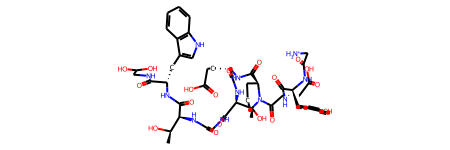

In [60]:
stripped_mol

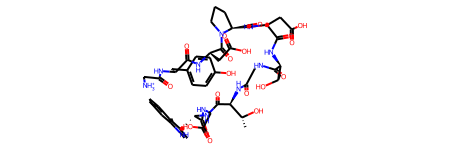

In [61]:
stripped_chignolin

In [64]:
full_dihedrals

array([[2.79347945e+02, 2.15342901e+01, 1.59299979e+02, 2.72203596e+02,
        3.57835757e+02, 2.28262448e+02, 1.05316958e+01, 1.03502154e+02,
        1.01272391e+02, 3.50456568e+02, 7.80055571e+01, 1.92663160e+02,
        2.76706090e+02, 1.90284647e+02, 2.84234556e+02, 2.95266885e+02,
        2.77926191e+02, 9.56784467e+00, 1.51497699e+02, 2.38220945e+00,
        6.57365585e+01, 1.81922877e+02, 2.44069683e+02, 3.47749255e+02,
        3.86697386e+01, 2.98412125e+01, 2.79574674e+00, 5.19881362e+01,
        2.52316092e+02, 2.68207230e+02, 1.83286851e+02, 7.36607508e+01,
        7.40844634e+01, 8.56592422e+01, 3.36056418e+02, 1.54534494e+00,
        1.90876488e+02, 1.75360435e+02],
       [3.65126200e+01, 1.46775459e+02, 3.08467095e+02, 8.99157524e+01,
        2.56176785e+02, 1.74588970e+02, 3.51504842e+00, 4.92194794e+01,
        1.78124918e+02, 1.35020000e+02, 5.04040990e+01, 1.84358780e+02,
        2.55625471e+02, 1.67667613e+02, 6.50478961e+01, 1.80957761e+02,
        2.64286885e+02,

In [70]:
row_matches = []
for row in full_true_dihedrals:
    print(np.linalg.norm(full_dihedrals - row, axis=1))
    break

(18,)


In [19]:
x = np.array([[1,2],[3,4]])
np.sum(x, axis=1)

array([3, 7])

In [25]:
summed_net_corr = np.sum(torsion_net_corr,axis=1)
net_indices = np.argsort(summed_net_corr)

In [23]:
summed_true_corr = np.sum(true_corr,axis=1)
true_indices = np.argsort(summed_true_corr)

In [27]:
true_to_net = dict(zip(true_indices, net_indices))

In [28]:
true_to_net.values()

{3: 16,
 2: 14,
 20: 10,
 33: 27,
 30: 20,
 12: 11,
 19: 21,
 24: 12,
 37: 3,
 28: 9,
 25: 18,
 31: 2,
 35: 36,
 5: 33,
 9: 22,
 36: 29,
 0: 26,
 21: 32,
 34: 19,
 11: 4,
 15: 34,
 26: 37,
 8: 15,
 23: 24,
 1: 17,
 4: 31,
 14: 7,
 13: 35,
 27: 5,
 32: 8,
 29: 6,
 18: 1,
 22: 0,
 7: 13,
 6: 30,
 10: 25,
 16: 28,
 17: 23}

In [31]:
print(mol.GetNumHeavyAtoms())
print(chignolin.GetNumHeavyAtoms())

77
77


Text(0.5, 1.0, '$Truth$')

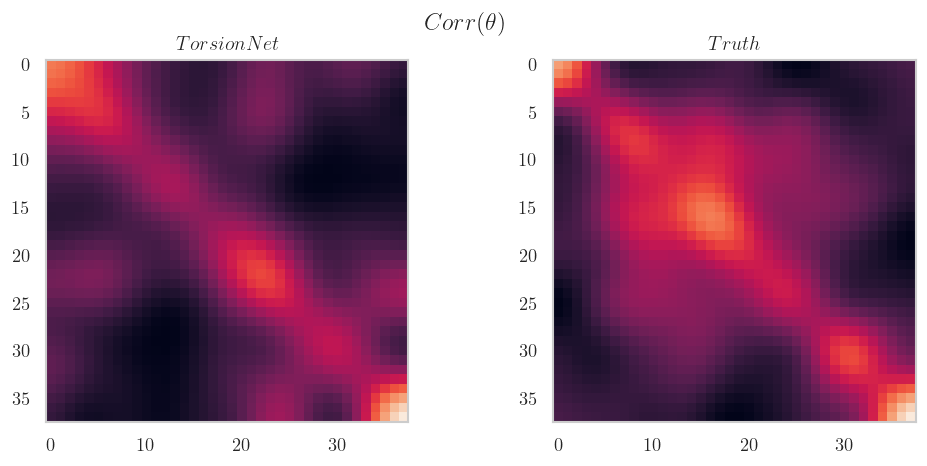

In [135]:
from scipy.ndimage.filters import gaussian_filter

torsion_net_corr_blurred = gaussian_filter(testing_net_corr, sigma=3)
true_corr_blurred = gaussian_filter(true_corr, sigma=3)

fig, axs = plt.subplots(1, 2, figsize=(10, 4), dpi=120)
axs[0].imshow(torsion_net_corr_blurred)
axs[1].imshow(true_corr_blurred)

fig.suptitle('$Corr(\\theta)$')
axs[0].set_title('$TorsionNet$')
axs[1].set_title('$Truth$')

In [68]:
def swap(testing_net_corr, i, j):
    tmp = testing_net_corr[i,:].copy()
    testing_net_corr[i,:] = testing_net_corr[j,:].copy()
    testing_net_corr[j,:] = tmp

    tmp = testing_net_corr[:,i].copy()
    testing_net_corr[:,i] = testing_net_corr[:,j].copy()
    testing_net_corr[:,j] = tmp

    return testing_net_corr

In [134]:
testing_net_corr = torsion_net_corr.copy() 
pairs = [
    (10 + 10, 30 - 2),
    (11 + 10, 31 - 2),
    (12 + 10, 32 - 2),
    # (13 + 7, 33 - 2),
    # (14 + 7, 34 - 2),
    # (15 + 7, 35 - 2),
    # (16 + 7, 36 - 2),
]

for pair in pairs:
    testing_net_corr = swap(testing_net_corr, pair[0], pair[1])

In [115]:
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2, init='random').fit_transform(full_true_dihedrals)
X_embedded.shape

(18, 2)

<AxesSubplot:>

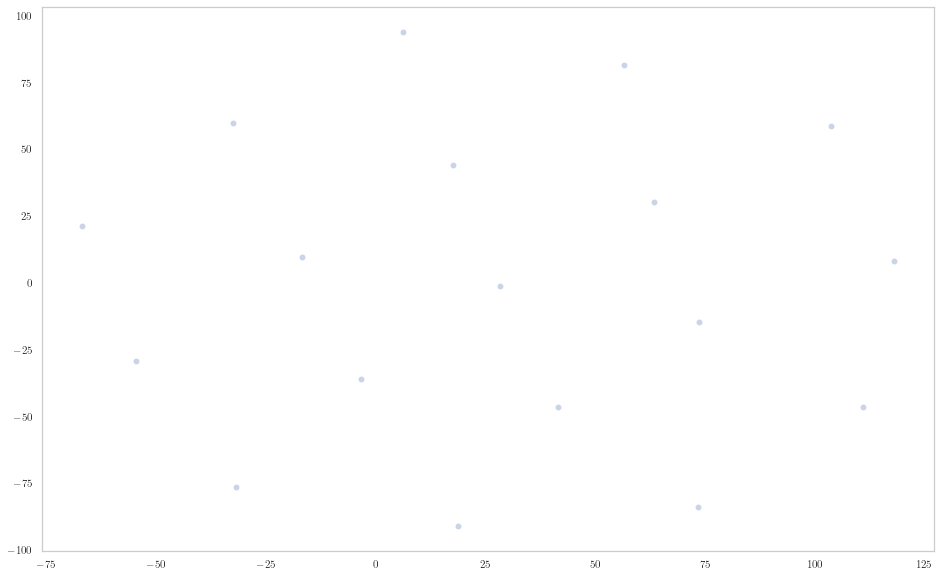

In [116]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x=X_embedded[:,0], 
    y=X_embedded[:,1],
    palette=sns.color_palette("hls", 10),
    legend="full",
    alpha=0.3
)

In [136]:
from idp_rl.environments.environment_components.forcefield_mixins import CharMMMixin, MMFFMixin
from idp_rl.molecule_generation.generate_chignolin import generate_chignolin

import copy
import numpy as np
import openmm
import rdkit.Chem.AllChem as Chem

charmm_sim = CharMMMixin()
charmm_sim._seed("chignolin/GYDPETGTWG")

chignolin = generate_chignolin()
chignolin.RemoveAllConformers()
Chem.EmbedMolecule(chignolin, useRandomCoords=True)
pre_chignolin_energy = charmm_sim._get_conformer_energy(chignolin, 0)
charmm_sim._optimize_conf(chignolin, 0)


ModuleNotFoundError: No module named 'openmm'